In [1]:
import torch, torchvision, cv2, PIL, os, random
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Dataset

In [2]:
total_train_pd = pd.read_csv(f"/home/user1/바탕화면/DACON 퍼즐/train.csv")
total_test_pd = pd.read_csv(f"/home/user1/바탕화면/DACON 퍼즐/test.csv")

In [3]:
# img_path 불러오기
pd_train_ID = total_train_pd["ID"]
pd_test_ID = total_test_pd["ID"]

# ID, img_path 제거하고 label만 남기기
pd_train_label = total_train_pd.drop(['ID', 'img_path'], axis=1)

print(f"Train_ID[0]: {pd_train_ID.iloc[0]}")

# 행 단위로 Label data 읽어오기
print(f"Train_Label[0]: {pd_train_label.iloc[0].to_numpy()}")

Train_ID[0]: TRAIN_00000
Train_Label[0]: [ 8  1 16 12  5 10 14  2 13  4  7  3  6  9 11 15]


In [4]:
def label_to_numpy(total_label):
    length = len(total_label)
    label = []

    for i in range(length):
        label.append(total_label.iloc[i].to_numpy())
    
    return np.array(label)

In [5]:
train_label = label_to_numpy(pd_train_label)
print(f"TRAIN_LABEL_SIZE: {train_label.shape}")

TRAIN_LABEL_SIZE: (70000, 16)


In [6]:
def img_path_list(ID, train):
    path = f"/home/user1/바탕화면/DACON 퍼즐/"
    img_path = []
    size = len(ID)

    if train is True:
        path = f"{path}train/"
        for i in range(size):
            img_path.append(f"{path}{ID[i]}.jpg")
    else:
        path = f"{path}test/"
        for i in range(size):
            img_path.append(f"{path}{ID[i]}.jpg")
    
    return img_path

In [7]:
train_img_path = img_path_list(pd_train_ID, True)
print(f"No. of TRAIN IMAGES: {len(train_img_path)}")
print(f"TRAIN_IMG_PATH[0]: {train_img_path[0]}")

No. of TRAIN IMAGES: 70000
TRAIN_IMG_PATH[0]: /home/user1/바탕화면/DACON 퍼즐/train/TRAIN_00000.jpg


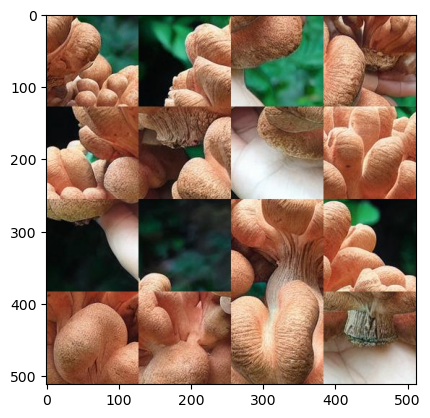

In [8]:
# Sample 이미지 -> TRAIN_00000
sample = PIL.Image.open(train_img_path[0])
plt.imshow(sample)

In [9]:
# GRID: 4x4/3x3/2x2 -> 몇 by 몇의 퍼즐인가?
def split_image(img, grid):
    orig_img = np.array(img)
    size = len(orig_img)
    grid_size = int(size/grid)
    results = []
    
    for i in range(grid):
        for j in range(grid):
            results.append(orig_img[grid_size*i:grid_size*(i+1), grid_size*j:grid_size*(j+1)])
    
    return results

In [10]:
# 이미지의 Left/Right/Top/Bottom edge pixel를 반환
def LRTB(box):
    left = box[:, 0]
    right = box[:, 127]
    top = box[0, :]
    bottom = box[127, :]

    return left, right, top, bottom

In [22]:
# Algorithms to search adjacent boxes
#1) RGB 채널의 평균값에 대해 SUB -> AVG
def avg_diff(edge1, edge2):
    avg1 = np.mean(edge1)
    avg2 = np.mean(edge2)
    diff = abs(avg1 - avg2)
    total_err = np.mean(diff)
    
    return total_err

#2) RGB 채널 별로 SUB -> 채널 별로 pixel값의 평균 -> RGB 총합의 평균
def column_avg(edge1, edge2):
    R_diff = np.mean(abs(edge1[:,0] - edge2[:,0]))
    G_diff = np.mean(abs(edge1[:,1] - edge2[:,1]))
    B_diff = np.mean(abs(edge1[:,2] - edge2[:,2]))
    result = np.mean(R_diff + G_diff + B_diff)

    return result

#3) RGB 채널의 평균값 -> GRAYSCALE로 변환해서 SUB & AVG
def gray_scale(edge1, edge2):
    gray1 = (edge1[:,0] + edge1[:,1] + edge1[:,2])/3
    gray2 = (edge2[:,0] + edge2[:,1] + edge2[:,2])/3
    return np.mean(abs(gray1-gray2))

In [56]:
# 반복문 제대로 짜야함 -> 지금 대충 짠거
# 반복하다가 pair 찾으면 List에서 제거 (더 이상 pair 찾을 필요 없는 애들)
search_standard = ["LR", "RL", "TB", "BT"]  # [0, 1, 2, 3]
search_algorithms = ["Sub&Avg", "Avg&Sub", "Grayscale"]

# list index와 puzzle index 불일치 -> 간단하게 통일할 수 있는 방법 생각해보기 (list의 첫번째 원소를 dummy로 설정?)

def search_adjacent(img, idx, standard, search_algorithm):
    true_idx = idx - 1
    overall_standards = [[0, 1], [1, 0], [2, 3], [3, 2]]  # [LR, RL, TB, BT]
    standard_indexes = overall_standards[standard]
    splitted_list = split_image(img, 4)  # [a~p]: 16개로 쪼개진 image -> LIST로 저장 (index로 접근)
    curr = splitted_list[true_idx]
    curr_edges = LRTB(curr)  # L, R, T, B 순으로 LIST에 저장
    curr_edge = curr_edges[standard_indexes[0]]
    err_list = []
    for j in range(16):
        pair = splitted_list[j]
        pair_edges = LRTB(pair)
        pair_edge = pair_edges[standard_indexes[1]]
        err_list.append(search_algorithm(curr_edge, pair_edge))

    err_list = np.array(err_list)
    closest = np.argmin(err_list)
    pair = splitted_list[closest]

    return idx, closest+1, err_list, closest # 각자 box 이미지의 index도 반환해야 함 -> CSV파일에 Label 저장해야 함

In [103]:
def find_ends(img, search_algorithm):
    empty = []
    L_errors = R_errors = T_errors = B_errors = empty
    left_ends = right_ends = top_ends = bottom_ends = empty

    for i in range(1, 17):  # box1~box16까지 search
        _, _, L_err_list, L_closest = search_adjacent(img, i, 0, search_algorithm)  # L_curr = right, L_pair = left
        _, _, R_err_list, R_closest = search_adjacent(img, i, 1, search_algorithm)  # R_curr = left, R_pair = right
        _, _, T_err_list, T_closest = search_adjacent(img, i, 2, search_algorithm)  # T_curr = bottom, T_pair = top
        _, _, B_err_list, B_closest = search_adjacent(img, i, 3, search_algorithm)  # B_curr = top, B_pair = bottom
        # 16 boxes에 대해 searching error를 list로 저장
        L_errors.append(L_err_list[L_closest])
        R_errors.append(R_err_list[R_closest])
        T_errors.append(T_err_list[T_closest])
        B_errors.append(B_err_list[B_closest])
    for _ in range(4):
        left_ends.append(np.argmax(L_errors)+1)
        right_ends.append(np.argmax(R_errors)+1)
        top_ends.append(np.argmax(T_errors)+1)
        bottom_ends.append(np.argmax(B_errors)+1)
        L_errors = np.delete(L_errors, np.argmax(L_errors))
        R_errors = np.delete(R_errors, np.argmax(R_errors))
        T_errors = np.delete(T_errors, np.argmax(T_errors))
        B_errors = np.delete(B_errors, np.argmax(B_errors))

    return left_ends, right_ends, top_ends, bottom_ends

In [104]:
left_ends, right_ends, top_ends, bottom_ends = find_ends(sample, gray_scale)

def find_duplicates(list1, list2):
    common_elements = set(list1) & set(list2)
    return list(common_elements)

left_top = find_duplicates(left_ends, top_ends)
right_top = find_duplicates(right_ends, top_ends)
left_bottom = find_duplicates(left_ends, bottom_ends)
right_bottom = find_duplicates(right_ends, bottom_ends)
print(f"LEFT TOP: {left_top}, RIGHT TOP: {right_top}, LEFT BOTTOM: {left_bottom}, RIGHT BOTTOM: {right_bottom}")

LEFT TOP: [3.4453125000000004, 6.921875, 7.356770833333335, 9.729166666666668, 10, 12.135416666666666, 13.09375, 14.815104166666668, 13.15625, 16.372395833333332, 16.669270833333336, 17.526041666666668, 19.674479166666664, 19.75, 17.411458333333336, 22.065104166666664, 23.122395833333336, 23.669270833333336, 23.364583333333336, 22.8203125, 22.4296875, 27.135416666666668, 25.236979166666668, 25.455729166666668, 31.101562500000004, 23.40625, 26.83333333333333, 26, 56, 12, 15.419270833333334, 16.755208333333332, 16.494791666666664, 17.513020833333336, 17.283854166666668, 18.93489583333333, 18.828125, 18.416666666666664, 18.997395833333336, 18.760416666666668, 19.950520833333332, 19.283854166666664, 19.6484375, 20.752604166666664, 20.557291666666664, 21.888020833333332], RIGHT TOP: [3.4453125000000004, 6.921875, 7.356770833333335, 9.729166666666668, 10, 12.135416666666666, 13.09375, 14.815104166666668, 13.15625, 16.372395833333332, 16.669270833333336, 17.526041666666668, 19.674479166666664

In [17]:
# bottom_ends = [16, 7, 3, 9]에 대해서 각각의 좌우를 비교한 뒤,
# 좌우가 가장 비슷한 아이들끼리 matching
# 16의 좌변과 7/3/9의 우변을 비교 -> 픽셀값이 가장 비슷한 두 box를 연결

sorted_bottom = [bottom_ends[2]]
err_list = []
first_boxes = split_image(sample, 4)
curr = first_boxes[bottom_ends[2]-1]  # curr -> box_3
for i in range(len(bottom_ends)):
    left, _, _, _ = LRTB(curr)
    pair = first_boxes[bottom_ends[i]-1]
    _, right, _, _ = LRTB(pair)
    err_list.append(avg_diff(left, right))

pair_idx = np.argmin(err_list)
pair = bottom_ends[pair_idx]
print(pair)
sorted_bottom.append(pair)

16


In [18]:
err_list = []
curr = first_boxes[pair-1]  # curr -> box_16
for i in range(len(bottom_ends)):
    left, _, _, _ = LRTB(curr)
    pair = first_boxes[bottom_ends[i]-1]
    _, right, _, _ = LRTB(pair)
    err_list.append(avg_diff(left, right))

pair_idx = np.argmin(err_list)
pair = bottom_ends[pair_idx]
print(pair)
sorted_bottom.append(pair)

7


In [19]:
err_list = []
curr = first_boxes[pair-1]  # curr -> box_7
for i in range(len(bottom_ends)):
    left, _, _, _ = LRTB(curr)
    pair = first_boxes[bottom_ends[i]-1]
    _, right, _, _ = LRTB(pair)
    err_list.append(avg_diff(left, right))

pair_idx = np.argmin(err_list)
pair = bottom_ends[pair_idx]
sorted_bottom.append(pair)
sorted_bottom.reverse()
print(sorted_bottom)

9
[9, 7, 16, 3]


In [20]:
# sorted_bottom에서 시작해서 위의 box들을 찾는다

remaining_idx = []
for i in range(1,17):
    remaining_idx.append(i)

remaining_idx = set(remaining_idx).symmetric_difference(set(sorted_bottom))
remaining_idx = list(remaining_idx)

In [21]:
row3= []
for i in range(len(sorted_bottom)):
    curr = sorted_bottom[i]
    _, _, top, _ = LRTB(first_boxes[curr-1])
    err_list = []
    for j in range(len(remaining_idx)):
        pair = remaining_idx[j]
        _, _, _, bottom = LRTB(first_boxes[pair-1])
        err = avg_diff(top, bottom)
        err_list.append(err)
    idx = np.argmin(err_list)
    true_pair = remaining_idx[idx]
    row3.append(true_pair)

print(row3)

[14, 13, 15, 4]


In [22]:
# R/G/B 3 channel로 분리하는 함수
def RGB_slicing(img, idx):
    splitted = split_image(img, 4)
    box = splitted[idx]
    R = box[:, :, 0]
    G = box[:, :, 1]
    B = box[:, :, 2]

    return R, G, B

# 이미지를 좌우 방향으로 결합하는 함수
def LR_merge(left, right):
    merged = np.concatenate((left, right), axis=1)
    return merged

In [23]:
# R1, G1, B1 = RGB_slicing(sample, 0)
# R11, G11, B11 = RGB_slicing(sample, 10)

# R_merged = LR_merge(R11, R1)
# G_merged = LR_merge(G11, G1)
# B_merged = LR_merge(B11, B1)

# plt.subplot(3,1,1), plt.imshow(R_merged)
# plt.subplot(3,1,2), plt.imshow(G_merged)
# plt.subplot(3,1,3), plt.imshow(B_merged)